In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [4]:
property_meta = pd.read_csv('../data/curated/properties.csv').reset_index()
property_external = pd.read_csv('../data/curated/api_distance_to_property.csv')
property_internal = property_meta[['index','type','Beds','Baths','Parking','weekly_cost']]

In [5]:
property_cost = property_meta[['weekly_cost']]

In [6]:
# Merge all attributes related to a property
property_attr = pd.merge(property_internal,property_external, on = 'index').drop('index',axis = 1)

In [7]:
property_attr.describe()

,Beds,Baths,Parking,weekly_cost,numSchool_3km,numHospital_1km,numStation_1km,numShopping_3km,numFacility_3km,cbd_route,facility_route,hospital_route,shopping_route,station_route,school_route
count,9082.000000,9082.000000,9082.000000,9082.000000,9082.000000,9082.000000,9082.000000,9082.000000,9082.000000,9082.000000,9082.000000,9082.000000,9082.000000,9082.000000,9082.000000
mean,2.611209,1.522242,1.322726,486.772737,34.445276,2.499890,2.614182,6.820744,51.679146,38355.007495,1951.257904,26802.788268,21305.610447,26349.020074,2245.692083
std,1.075202,0.637105,0.975478,178.854474,18.129948,3.798012,2.434430,8.051058,25.643510,69059.537708,10347.292721,50045.252989,46180.366686,66479.519586,12736.561705
min,0.000000,0.000000,0.000000,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,302.800000,0.400000,19.000000,12.200000,4.500000,2.300000
25%,2.000000,1.000000,1.000000,350.000000,20.000000,0.000000,0.000000,2.000000,32.000000,7164.000000,525.000000,1323.200000,1389.875000,1039.825000,531.875000
50%,3.000000,1.000000,1.000000,490.000000,36.000000,1.000000,2.000000,3.000000,57.000000,15069.700000,833.300000,2332.850000,2316.800000,1853.900000,828.700000
75%,3.000000,2.000000,2.000000,600.000000,50.000000,3.000000,4.000000,7.000000,72.000000,34044.575000,1274.300000,14059.100000,13482.250000,13638.150000,1223.100000
max,9.000000,8.000000,9.000000,999.000000,69.000000,18.000000,10.000000,28.000000,99.000000,546057.700000,223158.800000,246490.300000,314939.500000,510644.300000,242457.000000


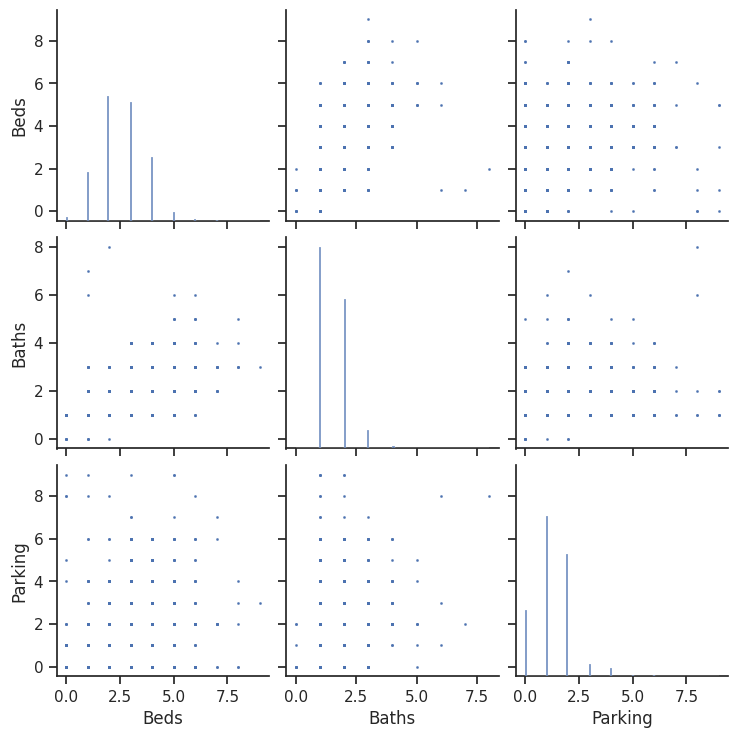

In [6]:
# Visulise internal features
sns.set(style="ticks", color_codes=True)
ax = sns.pairplot(property_attr[['Beds','Baths','Parking']], plot_kws=dict(s=3, edgecolor="b"))

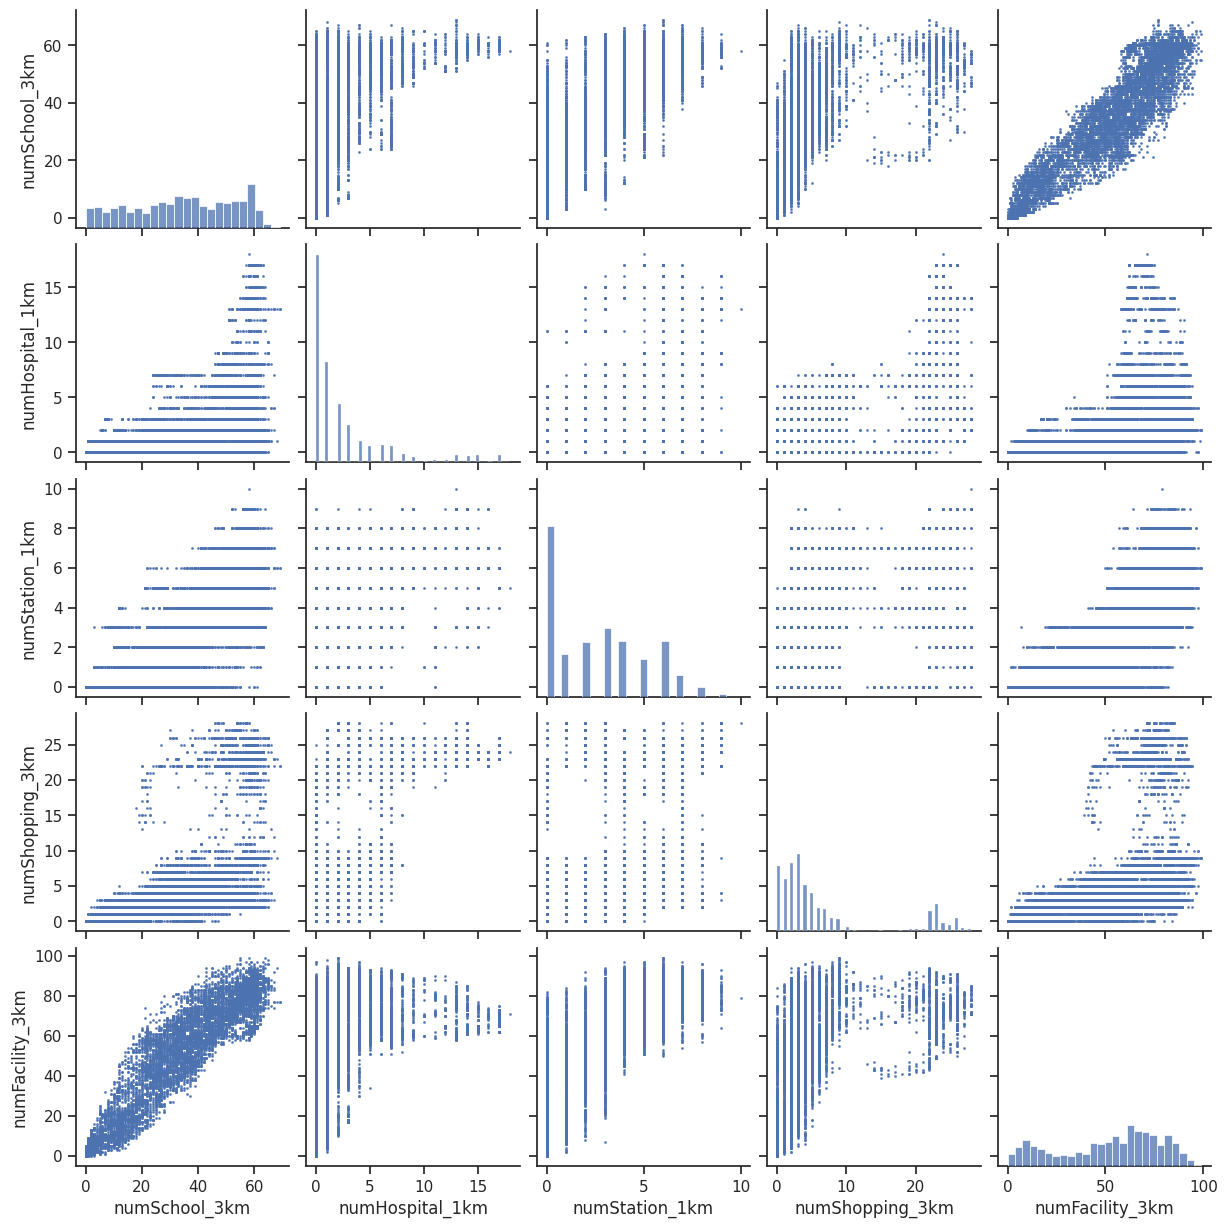

In [7]:
# Visualise number of buildings
ax = sns.pairplot(property_attr[['numSchool_3km','numHospital_1km',
                                 'numStation_1km', 'numShopping_3km', 'numFacility_3km']], plot_kws=dict(s=3, edgecolor="b"))

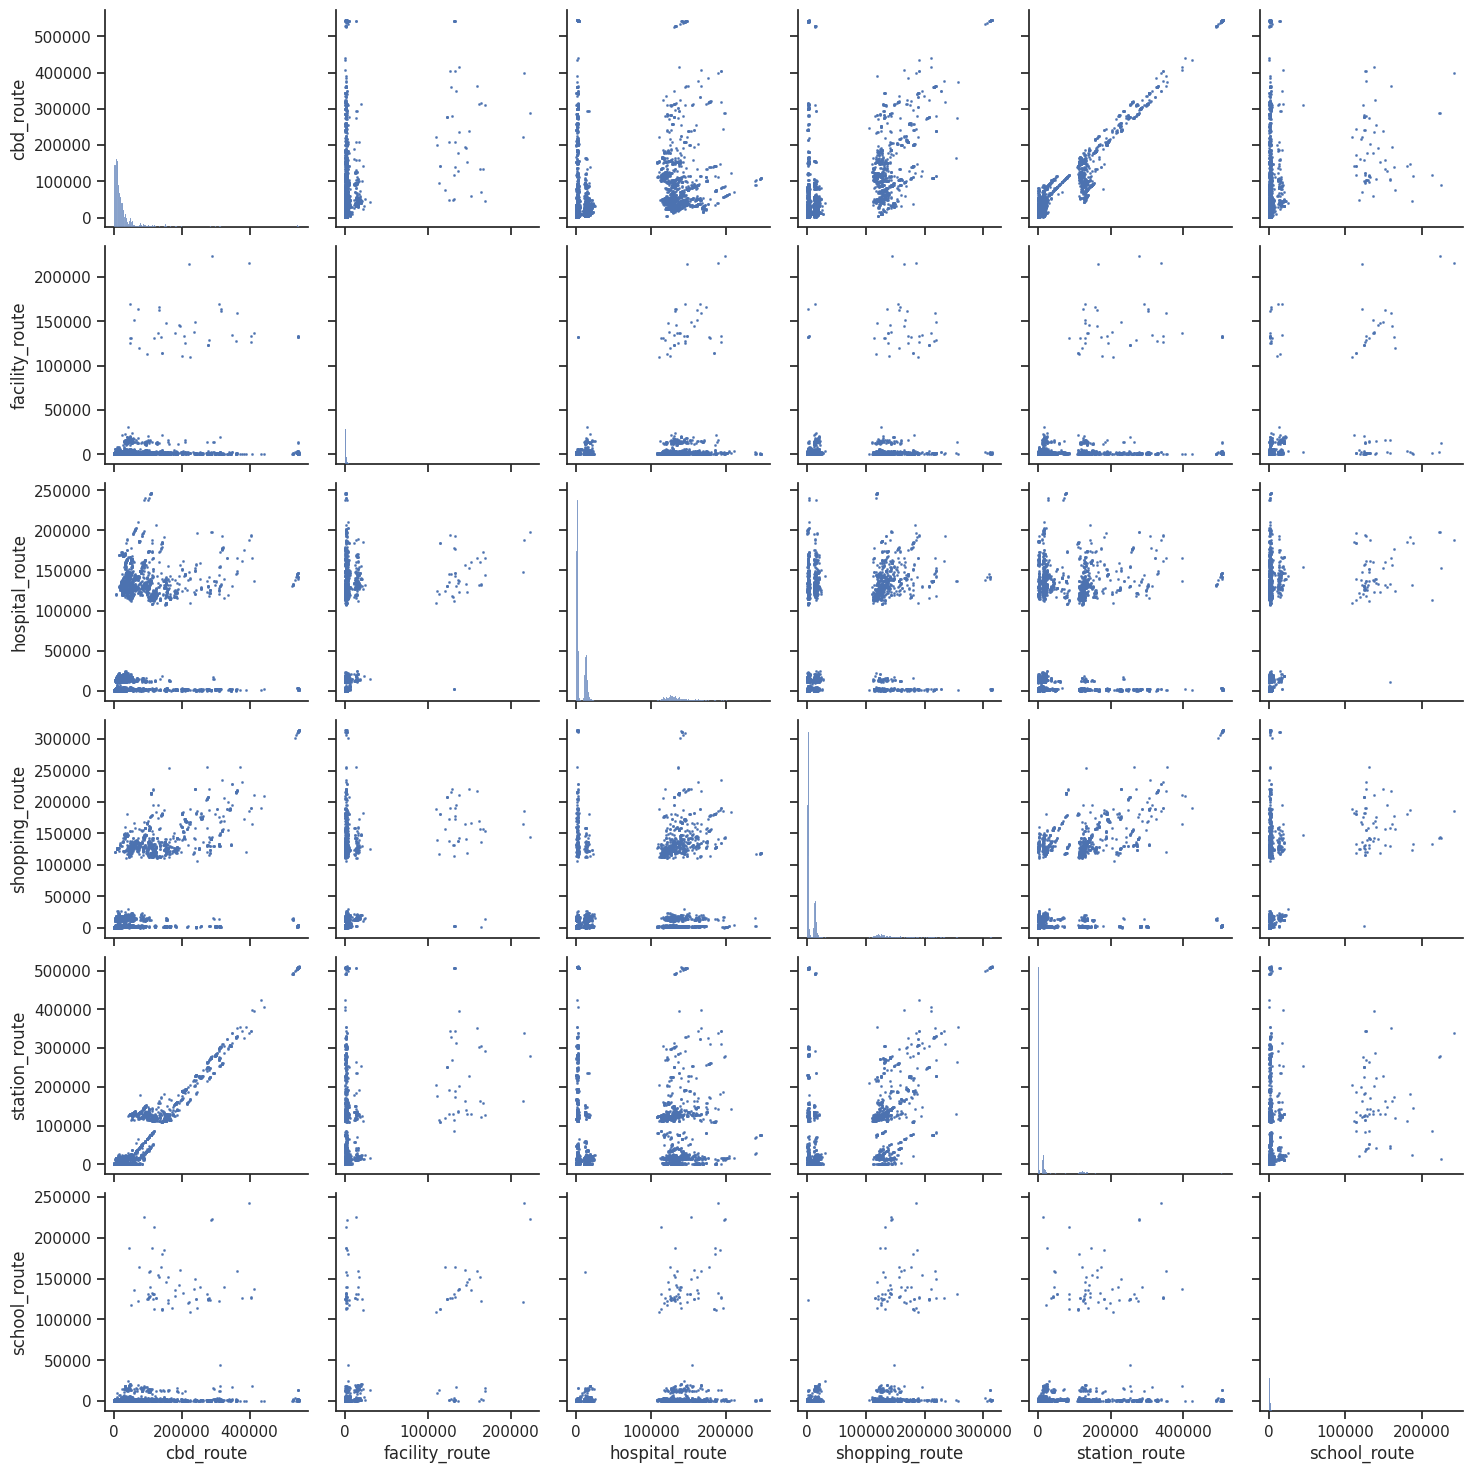

In [8]:
# Visualise distances
ax = sns.pairplot(property_attr[['cbd_route','facility_route','hospital_route', 
                                 'shopping_route', 'station_route', 'school_route']], plot_kws=dict(s=3, edgecolor="b"))

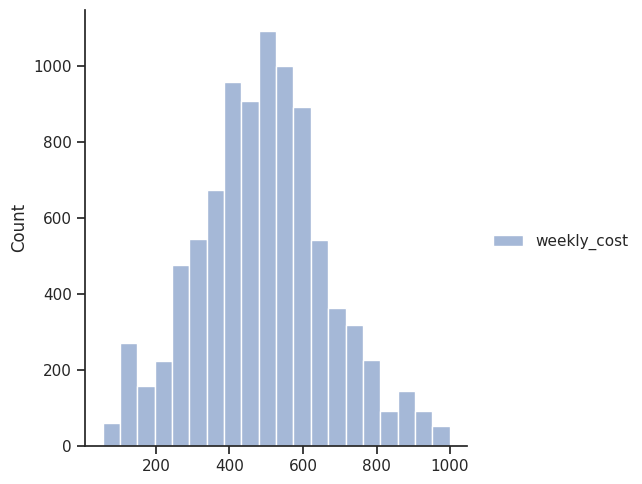

In [9]:
# Visualise response
ax = sns.displot(property_attr[['weekly_cost']], bins=20)

In [8]:
# Transform distance attribute using sqrt transformation
sqrt_columns = ['cbd_route','facility_route','hospital_route', 'shopping_route', 'station_route', 'school_route']
for c in [c for c in property_attr.columns if c in sqrt_columns]:
    property_attr[c] = np.sqrt(property_attr[c])
    property_attr.rename(columns = {c : f'sqrt({c})'}, inplace = True)

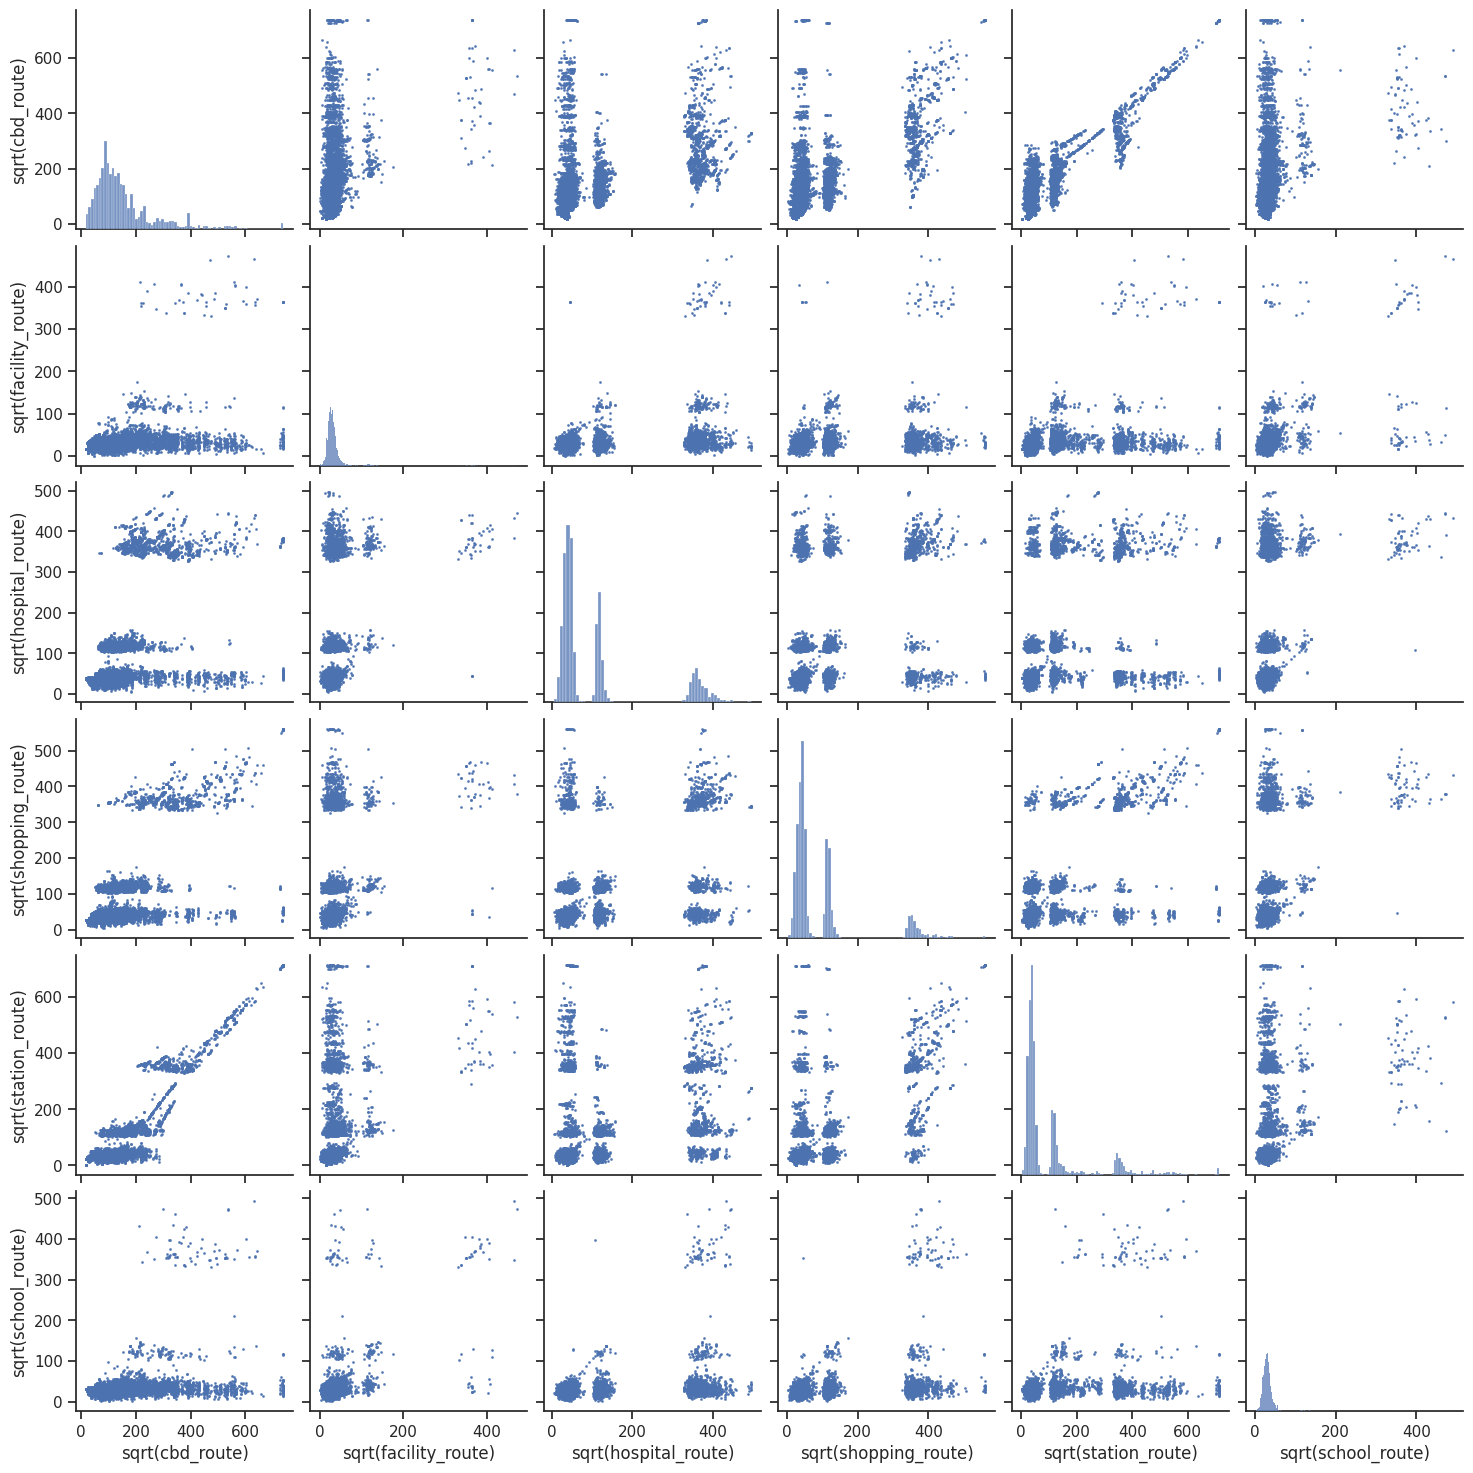

In [75]:
# Distribution after transformation
ax = sns.pairplot(property_attr[['sqrt(cbd_route)','sqrt(facility_route)','sqrt(hospital_route)', 
                                 'sqrt(shopping_route)', 'sqrt(station_route)', 'sqrt(school_route)']], 
                  plot_kws=dict(s=3, edgecolor="b"))

In [9]:
# Use One-Hot encoding to get dummy variable for categorical attribute
category = pd.get_dummies(property_attr['type'])

In [10]:
discretised = pd.concat([category, property_attr], axis = 1).drop('type', axis = 1)

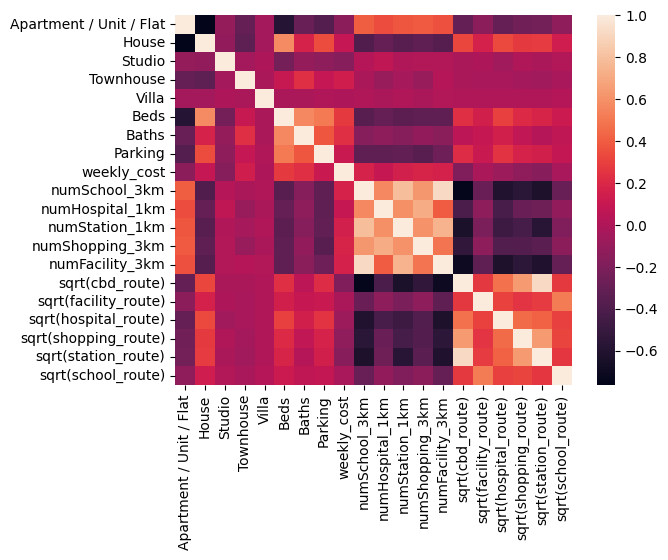

In [11]:
# Visualise correlation between attributes
ax = sns.heatmap(discretised.corr())
plt.savefig('../plots/property_attr_heatmap',bbox_inches='tight')
plt.show()

In [12]:
'''
This function fit OLS model using given attributes,
We will use this to perform backward elimination to select significant attributes
'''
def get_stats():
    x = discretised[columns]
    y = discretised['weekly_cost']
    result = sm.OLS(y, x).fit()
    return result

In [13]:
# Add Intersection term before attributes
discretised = sm.add_constant(discretised)
discretised.rename({'const':'(Intercept)'}, axis=1, inplace=True)

In [14]:
# Begin backward elimination
columns = list(discretised.columns)
columns.remove('weekly_cost')
cur_model = get_stats()
print(cur_model.summary())

                            OLS Regression Results                            
Dep. Variable:            weekly_cost   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     134.8
Date:                Mon, 03 Oct 2022   Prob (F-statistic):               0.00
Time:                        13:19:43   Log-Likelihood:                -58914.
No. Observations:                9082   AIC:                         1.179e+05
Df Residuals:                    9063   BIC:                         1.180e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
(Intercept)               

In [15]:
columns.remove('sqrt(hospital_route)')
cur_model = get_stats()
print(cur_model.summary())

                            OLS Regression Results                            
Dep. Variable:            weekly_cost   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     142.7
Date:                Mon, 03 Oct 2022   Prob (F-statistic):               0.00
Time:                        13:19:43   Log-Likelihood:                -58914.
No. Observations:                9082   AIC:                         1.179e+05
Df Residuals:                    9064   BIC:                         1.180e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
(Intercept)               

In [16]:
columns.remove('sqrt(facility_route)')
cur_model = get_stats()
print(cur_model.summary())

                            OLS Regression Results                            
Dep. Variable:            weekly_cost   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     151.6
Date:                Mon, 03 Oct 2022   Prob (F-statistic):               0.00
Time:                        13:19:43   Log-Likelihood:                -58914.
No. Observations:                9082   AIC:                         1.179e+05
Df Residuals:                    9065   BIC:                         1.180e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
(Intercept)               

In [17]:
columns.remove('sqrt(shopping_route)')
cur_model = get_stats()
print(cur_model.summary())

                            OLS Regression Results                            
Dep. Variable:            weekly_cost   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     161.6
Date:                Mon, 03 Oct 2022   Prob (F-statistic):               0.00
Time:                        13:19:43   Log-Likelihood:                -58915.
No. Observations:                9082   AIC:                         1.179e+05
Df Residuals:                    9066   BIC:                         1.180e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
(Intercept)               

In [18]:
columns.remove('sqrt(station_route)')
cur_model = get_stats()
print(cur_model.summary())

                            OLS Regression Results                            
Dep. Variable:            weekly_cost   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     172.9
Date:                Mon, 03 Oct 2022   Prob (F-statistic):               0.00
Time:                        13:19:45   Log-Likelihood:                -58916.
No. Observations:                9082   AIC:                         1.179e+05
Df Residuals:                    9067   BIC:                         1.180e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
(Intercept)               

In [19]:
columns.remove('Parking')
cur_model = get_stats()
print(cur_model.summary())

                            OLS Regression Results                            
Dep. Variable:            weekly_cost   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     185.9
Date:                Mon, 03 Oct 2022   Prob (F-statistic):               0.00
Time:                        13:19:45   Log-Likelihood:                -58918.
No. Observations:                9082   AIC:                         1.179e+05
Df Residuals:                    9068   BIC:                         1.180e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
(Intercept)               

In [20]:
columns.remove('numHospital_1km')
cur_model = get_stats()
print(cur_model.summary())

                            OLS Regression Results                            
Dep. Variable:            weekly_cost   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     201.1
Date:                Mon, 03 Oct 2022   Prob (F-statistic):               0.00
Time:                        13:19:46   Log-Likelihood:                -58920.
No. Observations:                9082   AIC:                         1.179e+05
Df Residuals:                    9069   BIC:                         1.180e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
(Intercept)               

In [21]:
columns.remove('numSchool_3km')
cur_model = get_stats()
print(cur_model.summary())

                            OLS Regression Results                            
Dep. Variable:            weekly_cost   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     219.0
Date:                Mon, 03 Oct 2022   Prob (F-statistic):               0.00
Time:                        13:19:47   Log-Likelihood:                -58921.
No. Observations:                9082   AIC:                         1.179e+05
Df Residuals:                    9070   BIC:                         1.180e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
(Intercept)               

In [22]:
columns.remove('sqrt(school_route)')
cur_model = get_stats()
print(cur_model.summary())

                            OLS Regression Results                            
Dep. Variable:            weekly_cost   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     240.4
Date:                Mon, 03 Oct 2022   Prob (F-statistic):               0.00
Time:                        13:19:48   Log-Likelihood:                -58923.
No. Observations:                9082   AIC:                         1.179e+05
Df Residuals:                    9071   BIC:                         1.179e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
(Intercept)               

In [23]:
# Get final parameters
params = cur_model.params
params = params.to_frame()

# Convert the transformed attribute to original while preserving the sign
params.rename(index={'sqrt(cbd_route)': 'cbd_route'}, inplace = True)
params.loc['cbd_route'] = -params.loc['cbd_route'] *  params.loc['cbd_route']

In [24]:
params.columns = ['Estimate']
params.to_csv('../data/curated/q1_result.csv')